In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/faster_rcnn_rilab')


In [2]:
import ai2thor
from ai2thor.controller import Controller
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map2 import single_scenemap
from ithor_tools.astar import astar
import random
from IPython.display import display
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
from moviepy.editor import ImageSequenceClip,VideoFileClip
import math

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [3]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation

from model.ssl_score.dino_score import cosine_distance_torch


In [37]:
controller = Controller(platform = CloudRendering)
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,
    fieldOfview = 90,
    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7fd3135b45e0
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [38]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
objects = controller.last_event.metadata['objects']
print(scene_bounds)

[[1.5, 3.200000286102295], [1.5, -2.799999713897705], [-4.400001049041748, 3.200000286102295], [-4.400001049041748, -2.799999713897705]]


In [39]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Floor,Floor|+00.00|+00.00|+00.00,Floor_b7d05094,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,1.5409,...,0.0,False,False,False,1.000,[Wood],,None,None,False
1,StoveBurner,StoveBurner|+00.84|+00.92|-01.10,StoveBurner_7e32c1bb,0.8420,0.9193,-1.0985,-0.0000,0.0000,0.0000,0.8557,...,0.0,False,False,False,0.000,None,,None,None,False
2,Cabinet,Cabinet|+00.65|+00.48|+00.24,Cabinet_5bf34838,0.6488,0.4750,0.2450,-0.0000,270.0000,0.0000,1.6845,...,0.0,False,False,False,0.000,None,,None,None,False
3,StoveBurner,StoveBurner|+01.08|+00.92|-01.50,StoveBurner_071647e1,1.0776,0.9193,-1.5042,-0.0000,0.0000,0.0000,1.1073,...,0.0,False,False,False,0.000,None,,None,None,False
4,StoveBurner,StoveBurner|+00.84|+00.92|-01.50,StoveBurner_bd86687e,0.8420,0.9193,-1.5042,-0.0000,0.0000,0.0000,0.8797,...,0.0,False,False,False,0.000,None,,None,None,False
5,Drawer,Drawer|+00.64|+00.76|-00.65,Drawer_074bdb84,0.6376,0.7556,-0.6500,-0.0000,270.0000,0.0000,0.8875,...,0.0,False,False,False,0.000,None,,None,None,False
6,Cabinet,Cabinet|+00.95|+02.16|-02.38,Cabinet_2fe8d304,0.9490,2.1600,-2.3760,-0.0000,270.0000,0.0000,1.9374,...,0.0,False,False,False,0.000,None,,None,None,False
7,CounterTop,CounterTop|-01.24|+00.97|-00.64,CounterTop_81593bc3,-1.2390,0.9690,-0.6430,-0.0000,0.0000,0.0000,1.3814,...,0.0,False,False,False,0.000,None,,None,None,False
8,CounterTop,CounterTop|+00.93|+00.95|-00.21,CounterTop_cbb462c5,0.9320,0.9468,-0.2080,-0.0000,0.0000,0.0000,1.3987,...,0.0,False,False,False,0.000,None,,None,None,False
9,StoveBurner,StoveBurner|+01.08|+00.92|-01.10,StoveBurner_5fa31b8b,1.0776,0.9193,-1.0985,-0.0000,0.0000,0.0000,1.0884,...,0.0,False,False,False,0.000,None,,None,None,False


In [40]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
# query_object = random.choice(objects)
query_object = objects[40] #20
query_object_name = query_object['objectType']

print(query_object_name)


PaperTowelRoll


-4.400001049041748 1.5 -2.799999713897705 3.200000286102295
0
(739, 725, 4)


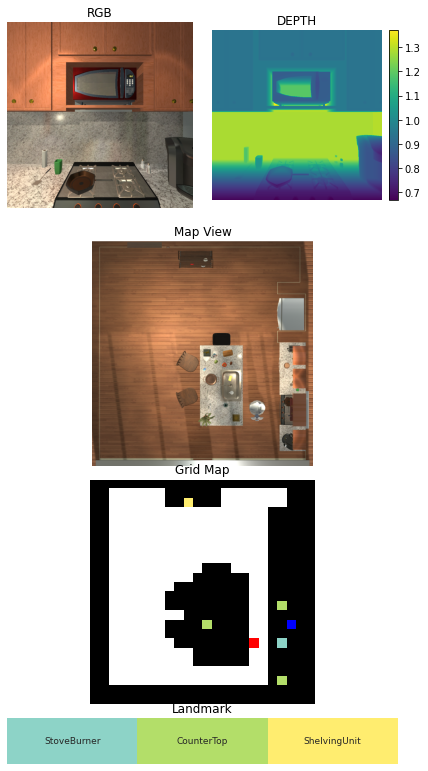

In [41]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.25,landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)


In [42]:
print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../faster_rcnn_rilab/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=19
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.PATH = '../faster_rcnn_rilab'

# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [43]:
device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../faster_rcnn_rilab/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

  nn.init.normal(layers.weight,std=0.01)

  nn.init.normal(layers.bias,0)



(739, 725, 4)


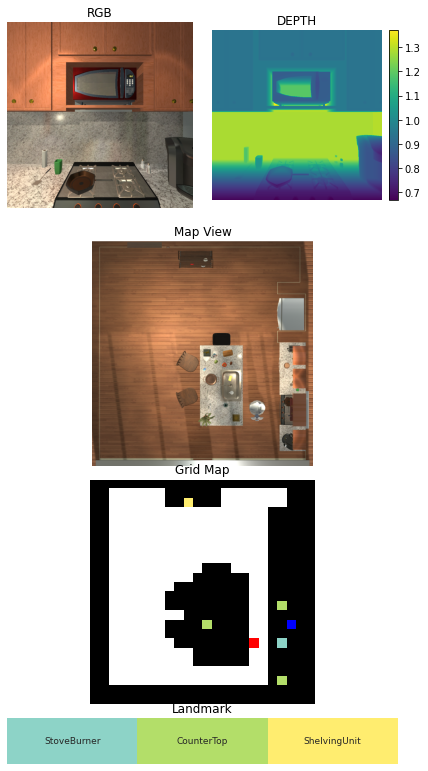

In [44]:
# controller.step(
#     action="RotateRight", degrees = 180
# )
# controller.step(
#     action="MoveRight",moveMagnitude = 1.0
# )
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)
img = controller.last_event.cv2img

In [45]:
pred = predictor(img)
pred = pred['instances']._fields

In [46]:
pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.3)[0]
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
scores = scores[index]

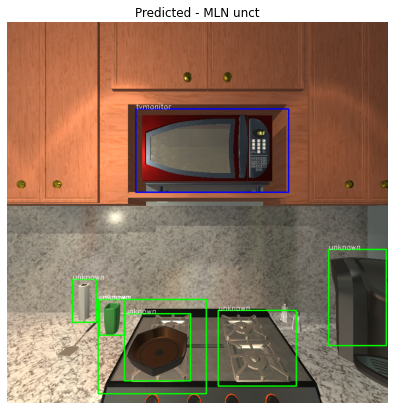

In [47]:
VOC_CLASS_NAMES = (
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'unknown'
)

# print(cos_sim)
plt.figure(figsize=(15,15))
demo_image = copy.deepcopy(img)
for bbox,label in zip(pred_boxes,pred_classes):
    if label == 20:
        color = (0,255,0)
    else:
        color = (255,0,0)
    # color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    # cv2.putText(demo_image, str(sc.item()), 
    #                         (int(bbox[0]), int(bbox[1])),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.title("Predicted - MLN unct")
plt.imshow(demo_image)
plt.axis('off')
plt.show()


### CLIP

In [48]:
import clip
from PIL import Image
from layers.wrappers import cat

In [49]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
new_query_object_name = ''
for i, letter in enumerate(query_object_name):
    if i and letter.isupper():
        new_query_object_name += ' '
    new_query_object_name += letter.lower()

text = clip.tokenize(["a photo of a {}".format(new_query_object_name)]).to(device)
text_features = clip_model.encode_text(text)

In [50]:
"a photo of a {}".format(new_query_object_name)

'a photo of a paper towel roll'

In [51]:
def preprocess(image,bboxs,clip_preprocess):
    res = []
    vis = []
    bboxs = np.asarray(bboxs,dtype=np.int16)
    for bbox in bboxs:
        y_u = bbox[2]
        y_b = bbox[0]
        x_r = bbox[3]
        x_l = bbox[1]
        crop = image[x_l:x_r,y_b:y_u,:]
        # Make boarder and resize
        y = y_u-y_b
        x = x_r-x_l
        length = max(x, y)

        top = int(length/2 - x/2)
        bottom = int(length/2 - x/2)
        left = int(length/2 - y/2)
        right = int(length/2 - y/2)

        borderType = cv2.BORDER_CONSTANT
        crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
        crop = cv2.resize(crop,(256,256))
        # convert from BGR to RGB
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        vis.append([crop])
        # convert from openCV2 to PIL
        pil_image=Image.fromarray(crop)
        temp = clip_preprocess(pil_image).unsqueeze(0)
        res.append(temp)
    return torch.cat(res,dim=0),np.concatenate(vis,axis=0)

In [52]:
img = controller.last_event.cv2img

index = (pred_classes==20)
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
patches,vis_patches = preprocess(img,pred_boxes.tensor.cpu().numpy(),clip_preprocess)
print(patches.shape,vis_patches.shape)

torch.Size([6, 3, 224, 224]) (6, 256, 256, 3)


In [53]:
image_features = clip_model.encode_image(patches.to(device))

In [54]:
dis = torch.matmul(text_features,image_features.T)
dis

tensor([[24.1406, 19.1562, 28.8594, 25.7031, 22.8125, 27.2969]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)

In [55]:
thres = 28
index = torch.where(dis>thres)[1]

show_patch = vis_patches[index.cpu().numpy()]
candidate_box = pred_boxes[index]

In [56]:
def to_rad(th):
    return th*math.pi / 180

width = 800
height = 800
fov = 90
# camera intrinsics
focal_length = 0.5 * width / math.tan(to_rad(fov/2))
fx, fy, cx, cy = (focal_length, focal_length, width/2, height/2)


In [57]:
import open3d as o3d
# Obtain point cloud
def object_coord(DEPTH,COLOR,agent_pos,agent_rot):
    depth = o3d.geometry.Image(DEPTH)
    color = o3d.geometry.Image(COLOR)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth,
                                                                depth_scale=1.0,
                                                                depth_trunc=3.0,
                                                                convert_rgb_to_intensity=False)
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
    # pcd.transform([[0, 1, 0, 0],
    #                 [1, 0, 0, 0],
    #                 [0, 0, -1, 0],
    #                 [0, 0, 0, 1]])
    rot = agent_rot['y']
    pcd.transform([[math.cos(rot), math.sin(rot), 0, agent_pos['x']],
                    [-math.sin(rot), math.cos(rot), 0, agent_pos['z']],
                    [0, 0, 1, 0.9],
                    [0, 0, 0, 1]])
    points = np.asarray(pcd.points)
    points = np.resize(points, (width,height,3))
    new = points[int(center[1]),int(center[0]),:]
    new = dict(x=new[0],y=new[2],z=new[1])
    return new

1


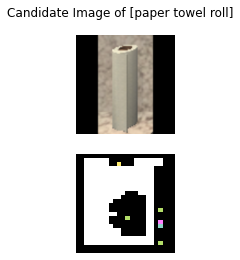

In [58]:
# plt.figure(figsize=(5,5))
plt.suptitle("Candidate Image of [{}]".format(new_query_object_name))
print(len(show_patch))
for e,sp in enumerate(show_patch):
    candidate_box_numpy = candidate_box.tensor.cpu().numpy()[e]
    center = [(candidate_box_numpy[0]+candidate_box_numpy[2])/2,(candidate_box_numpy[1]+candidate_box_numpy[3])/2]
    DEPTH = controller.last_event.depth_frame
    COLOR = controller.last_event.frame.astype(np.uint8)
    new = object_coord(DEPTH,COLOR,controller.last_event.metadata['agent']['position'],controller.last_event.metadata['agent']['rotation'])
    new_grid = sm.xyz2grid(new)
    plt.subplot(2,len(show_patch),e+1)
    plt.imshow(sp)
    plt.axis('off')

    plt.subplot(2,len(show_patch),e+len(show_patch)+1)
    temp = sm.grid_map.copy()
    temp[new_grid[0],new_grid[1],:] = [1,0.5,1]
    temp = np.rot90(temp)
    plt.imshow(temp)
    plt.axis('off')
plt.show()


candidate_depth = DEPTH[int(center[0]),int(center[1])]